In [97]:
import csv 
import cv2
import tensorflow as tf
import keras.backend as ktf
import numpy as np

lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    first = True
    for line in reader:
        if first :
            first = False
            continue
        lines.append(line)

images = []
measurements = []
LEFT_CORR = 0.25
RIGHT_CORR = 0.3
CENTRE_DROP_RATE = 0.50
MULTI_FACTOR = 1.3

count_added = 0
count_dropped = 0

for line in lines:
    centre_file = './data/IMG/'+ line[0].split('/')[-1]
    left_file   = './data/IMG/'+ line[1].split('/')[-1]
    right_file  = './data/IMG/'+ line[2].split('/')[-1]
    
    measurement = float(line[3])
    
    if np.random.uniform() < CENTRE_DROP_RATE :
        image = cv2.imread(centre_file )
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image =image[60:140,:,:]
        images.append(image)
        measurements.append(float(line[3]))
        count_dropped += 1
        
    if (measurement < -0.05 or measurement > 0.05 ):
        image = cv2.imread(centre_file )
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image =image[60:140,:,:]
        images.append(image)
        measurements.append(float(line[3]) * MULTI_FACTOR)
        count_added += 1
    
    image = cv2.imread(left_file )
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image =image[60:140,:,:]
    images.append(image)
    measurements.append(float(line[3]) + LEFT_CORR)
    
    image = cv2.imread(right_file )
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image =image[60:140,:,:]
    images.append(image)
    measurements.append(float(line[3]) - RIGHT_CORR)
    
    
        
print("count_dropped ", count_dropped)
print("count_added ", count_added)
    
X_train = np.array(images)
y_train = np.array(measurements)

print('X_train.shape',X_train.shape)
print('y_train.shape',y_train.shape)
# Preprocessing

count_dropped  3967
count_added  3155
X_train.shape (23194, 80, 320, 3)
y_train.shape (23194,)


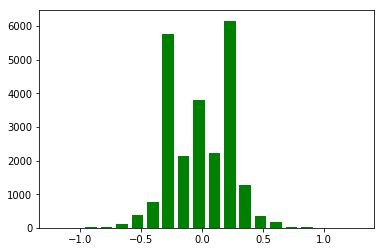

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.imshow(X_train[250])
Histo = plt.hist(y_train, facecolor='green',rwidth = 0.75, align = 'mid', bins = 20)

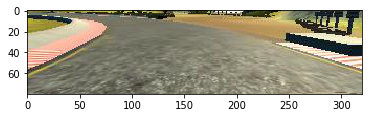

In [101]:
plt.imshow(X_train[50])
plt.savefig('./train.png')

In [88]:
# Resize
def resize(X):

    #return ktf.resize_images(X,64.0/80, 64.0/320, "channels_first")
    import tensorflow as tf
    return tf.image.resize_images(X,[32,128])




#MODEL ARCHITECTURE

from keras.models import Sequential
from keras.layers import Flatten,Dense,Activation,Lambda,Convolution2D,Dropout,MaxPooling2D

model = Sequential()

model.add(Lambda(lambda x: x/127.5 - 1,input_shape = (80,320,3)))
model.add(Lambda(resize))

model.add(Convolution2D(6,3,3))
model.add(Activation('relu'))
#model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(12,3,3))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(300))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(30))
model.add(Activation('relu'))

model.add(Dense(1))


model.compile(loss = 'mse', optimizer = 'adam')
history_object = model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 5, batch_size = 128)
### print the keys contained in the history object
print(history_object.history.keys())

model.save('model.h5')


Train on 18565 samples, validate on 4642 samples
Epoch 1/5
18565/18565 [==============================] - 159s - loss: 0.0607 - val_loss: 0.0234
Epoch 2/5
18565/18565 [==============================] - 149s - loss: 0.0153 - val_loss: 0.0213
Epoch 3/5
18565/18565 [==============================] - 139s - loss: 0.0118 - val_loss: 0.0262
Epoch 4/5
18565/18565 [==============================] - 340s - loss: 0.0090 - val_loss: 0.0279
Epoch 5/5
18565/18565 [==============================] - 144s - loss: 0.0064 - val_loss: 0.0203
dict_keys(['val_loss', 'loss'])


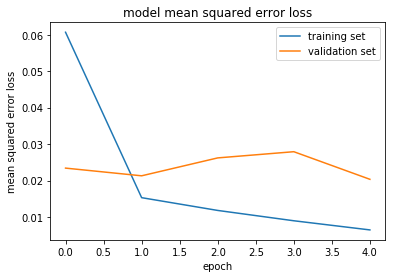

In [91]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()